In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from google.colab.patches import cv2_imshow 

In [16]:
model = load_model("/content/drive/My Drive/Colab Notebooks/model2.h5")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)       

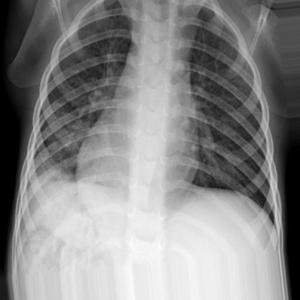

In [0]:
ORIGINAL = '/content/drive/My Drive/Colab Notebooks/covid.jpeg'

DIM = 300

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image

In [11]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(preds)

[[1. 0. 0.]]


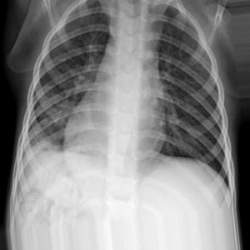

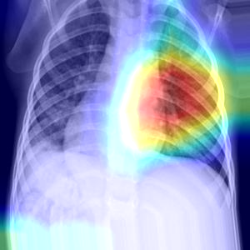

In [15]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_3')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))


  img = cv2.imread(orig)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

gradCAM("/content/drive/My Drive/Colab Notebooks/covid.jpeg")
